In [1]:
import pandas as pd 

import matplotlib.pyplot as plt 

import numpy as np

In [2]:
df=pd.read_csv('ett.csv')
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [3]:
df.shape

(17420, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    17420 non-null  object 
 1   HUFL    17420 non-null  float64
 2   HULL    17420 non-null  float64
 3   MUFL    17420 non-null  float64
 4   MULL    17420 non-null  float64
 5   LUFL    17420 non-null  float64
 6   LULL    17420 non-null  float64
 7   OT      17420 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.1+ MB


In [5]:
df.isnull().sum()

date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

In [6]:
df.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,7.375141,2.242242,4.300239,0.881568,3.066062,0.856932,13.324672
std,7.067744,2.042342,6.826978,1.809293,1.164506,0.599552,8.566946
min,-22.705999,-4.756000,-25.087999,-5.934000,-1.188000,-1.371000,-4.080000
25%,5.827000,0.737000,3.296000,-0.284000,2.315000,0.670000,6.964000
50%,8.774000,2.210000,5.970000,0.959000,2.833000,0.975000,11.396000
75%,11.788000,3.684000,8.635000,2.203000,3.625000,1.218000,18.079000
max,23.643999,10.114000,17.341000,7.747000,8.498000,3.046000,46.007000


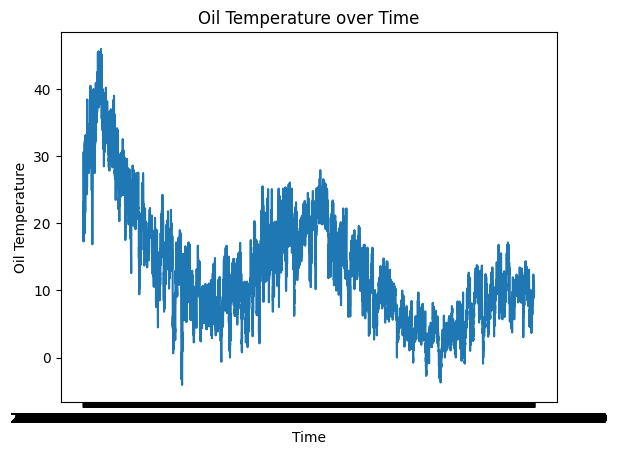

In [7]:
plt.plot(df['date'], df['OT'])
plt.title('Oil Temperature over Time')
plt.xlabel('Time')
plt.ylabel('Oil Temperature')
plt.show()

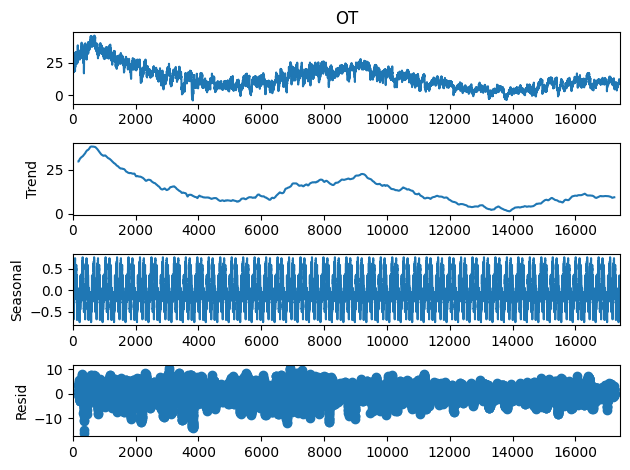

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['OT'], model='additive', period=365)
result.plot()
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Assume 'oil_temperature' is the target variable, and 'timestamp' is the time index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Feature scaling
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['OT']])

# Create input/output sequences for the time series model (LSTM)
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data)-sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Hyperparameter: Sequence length (for LSTM input)
sequence_length = 60
X, y = create_sequences(df_scaled, sequence_length)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))  # Single output for oil temperature

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
434/434 [==============================] - 42s 83ms/step - loss: 0.0036 - val_loss: 5.4262e-04
Epoch 2/100
434/434 [==============================] - 34s 79ms/step - loss: 0.0013 - val_loss: 3.1843e-04
Epoch 3/100
434/434 [==============================] - 33s 75ms/step - loss: 8.6522e-04 - val_loss: 2.7679e-04
Epoch 4/100
434/434 [==============================] - 34s 78ms/step - loss: 7.3030e-04 - val_loss: 2.7382e-04
Epoch 5/100
434/434 [==============================] - 33s 76ms/step - loss: 6.7227e-04 - val_loss: 2.1774e-04
Epoch 6/100
434/434 [==============================] - 31s 72ms/step - loss: 6.3882e-04 - val_loss: 1.9047e-04
Epoch 7/100
434/434 [==============================] - 35s 80ms/step - loss: 6.1351e-04 - val_loss: 2.4134e-04
Epoch 8/100
434/434 [==============================] - 34s 78ms/step - loss: 5.8533e-04 - val_loss: 2.1837e-04
Epoch 9/100
434/434 [==============================] - 37s 86ms/step - loss: 6.0551e-04 - val_loss: 2.1447e-04
Epoch 10/

109/109 [==============================] - 4s 24ms/step


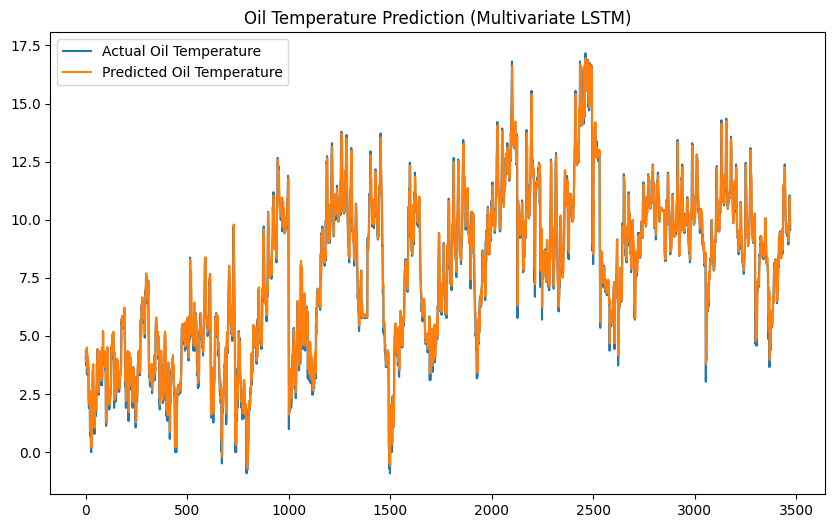

Mean Squared Error: 0.41724337373564546
Root Mean Squared Error: 0.6459437852751936


In [11]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and the test data
y_pred = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], X_test.shape[2] - 1))), axis=1))[:,0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:,0]

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label='Actual Oil Temperature')
plt.plot(y_pred, label='Predicted Oil Temperature')
plt.title('Oil Temperature Prediction (Multivariate LSTM)')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


Length of test_indices: 3472
Length of residuals: 3472


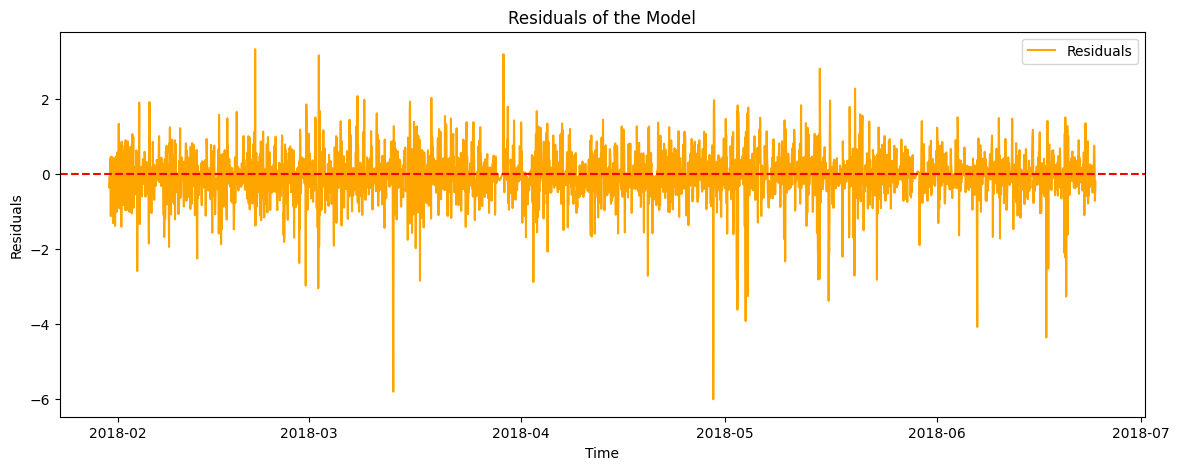

In [12]:
# Assuming y_test_actual and y_pred are already calculated
# Adjust test_indices based on the actual length of y_test_actual
test_indices = df.index[len(y_train):len(y_train) + len(y_test_actual)]  # Use length of y_test_actual

# Calculate residuals
residuals = y_test_actual - y_pred  # Ensure you're using the right predicted values

# Debugging: Print lengths for verification
print(f"Length of test_indices: {len(test_indices)}")
print(f"Length of residuals: {len(residuals)}")

# Plotting the residuals if lengths match

plt.figure(figsize=(14, 5))
plt.plot(test_indices, residuals, label='Residuals', color='orange')  # Plot residuals against test_indices
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of the Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()



Mean Squared Error: 0.41724337373564546
Root Mean Squared Error: 0.6459437852751936